## Simple Decycler - Technical Analysis Indicator

<br>
<br>

__load library__

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
from plotly.graph_objs import Line
import datetime as dt
from datetime import datetime, timedelta
import warnings
import plotly.io as pio

warnings.filterwarnings('ignore')

<br>
<br>

__retrieve data__

In [2]:
start_date = pd.to_datetime(dt.datetime.today() - timedelta(days = (180*3))).to_period('D')
end_date = pd.to_datetime(dt.datetime.today()).to_period('D')

In [3]:
df = yf.Ticker('TSLA')
df = df.history(start = start_date, end = end_date, interval = '1d')
df['Date'] = df.index
df = df.drop(['Dividends', 'Stock Splits'], axis = 1)
df['OHLC'] = (df['Open']+df['High']+df['Low']+df['Close'])/4
df

,Open,High,Low,Close,Volume,Date,OHLC
Date,,,,,,,
2021-02-26,700.000000,706.700012,659.510010,675.500000,41089200,2021-02-26,685.427505
2021-03-01,690.109985,719.000000,685.049988,718.429993,27136200,2021-03-01,703.147491
2021-03-02,718.280029,721.109985,685.000000,686.440002,23732200,2021-03-02,702.707504
2021-03-03,687.989990,700.700012,651.710022,653.200012,30208000,2021-03-03,673.400009
2021-03-04,655.799988,668.450012,600.000000,621.440002,65919500,2021-03-04,636.422501
...,...,...,...,...,...,...,...
2022-08-15,905.359985,939.400024,903.690002,927.960022,29786400,2022-08-15,919.102509
2022-08-16,935.000000,944.000000,908.650024,919.690002,29378800,2022-08-16,926.835007
2022-08-17,910.190002,928.969971,900.099976,911.989990,22922000,2022-08-17,912.812485


<br>

__simple decycler__

In [4]:
def simple_decycler(src, hp_period = 89, n_output = 150, show_hysteresis = True):
    """
    technical analysis indicator originated by John F. Ehlers
    by subtracting high-frequency components from price data, 
    while retain the low-frequency components of price data i.e. trends are kept intact with little to no lag
    including a hyteresis band
    """
    
    # Length
    n = len(src)
    
    # Variable
    alpha_1 = 0.0
    hp = [0.0]*n
    hysteresis_up = [0.0]*n
    hysteresis_down = [0.0]*n
    decycler = [0.0]*n
    pi = 2*np.arcsin(1)
    alpha_1 = (np.cos(.707*2*pi/hp_period) + np.sin(.707*2*pi/hp_period) - 1) / np.cos(.707*2*pi/hp_period)
    
    # Decycler
    for i in range(1, n):
        hp[0] = 0
        hp[i] = (1-alpha_1/2)*(1-alpha_1/2)*(src[i]-2*src[i-1]+src[i-2]) + 2*(1-alpha_1)*hp[i-1]-(1-alpha_1)*(1-alpha_1)*hp[i-2]
        decycler[i] = src[i]-hp[i]
        hysteresis_up[i] = decycler[i]*(1+(.5/100))
        hysteresis_down[i] = decycler[i]*(1-(.5/100))

    
    # Return
    decycler = decycler[n_output:]
    src = src[n_output:]

    if show_hysteresis:
        hysteresis_up = hysteresis_up[n_output:]
        hysteresis_down = hysteresis_down[n_output:]
        return [decycler, src, hysteresis_up, hysteresis_down]
    else:
        return[decycler, src]

In [5]:
decycler = pd.DataFrame(simple_decycler(df['OHLC'])).T
decycler.columns = ['Decycler', 'OHLC4', 'Upper Hysteresis', 'Lower Hysteresis']

<br>
<br>

__visualize results__

In [6]:
fig = go.Figure(data = [go.Candlestick(
    x = df['Date'],
    open = df['Open'],
    high = df['High'],
    low = df['Low'],
    close = df['Close']
)])

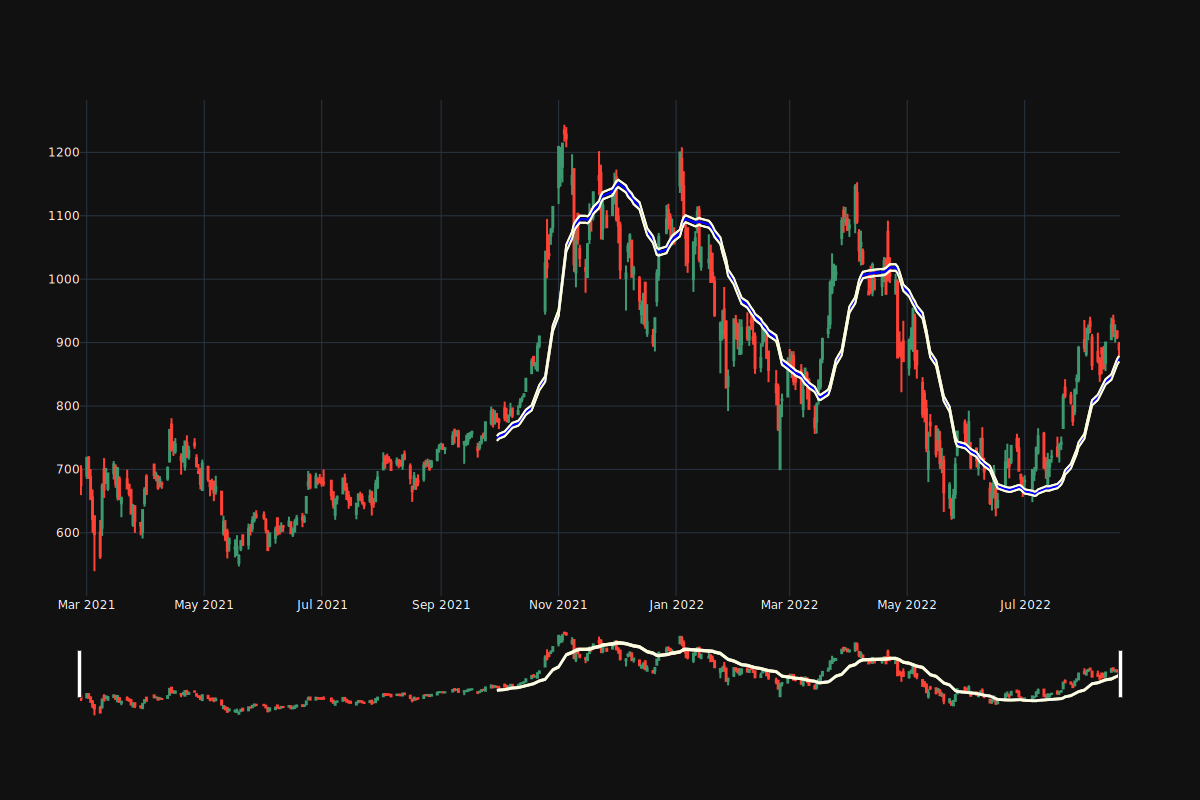

In [9]:
fig.update_layout(xaxis_rangeslider_visible = True,
                  width = 1200, 
                  height = 800, 
                  template = 'plotly_dark')

fig.add_trace(go.Line(
    x = df['Date'][-len(decycler):],
    y = decycler['Decycler'],
    line = dict(color = '#0000FF')
))

fig.add_trace(go.Line(
    x = df['Date'][-len(decycler):],
    y = decycler['Upper Hysteresis'],
    line = dict(color = '#FFFFE0')
))

fig.add_trace(go.Line(
    x = df['Date'][-len(decycler):],
    y = decycler['Lower Hysteresis'],
    line = dict(color = '#FFFFE0')
))

fig.update_layout(showlegend=False)

pio.write_html(fig, file='figure.html', auto_open=True)
fig.show("svg")

In [8]:
# {% include figure.html %}
# !pip install -U kaleido